# ANN Local Fit

Overview:

1. Start with a specific set of kinematic variables.  
2. Initialize a ANN with 4 Kins as input and 3 CFFs as output
3. Pick random starting points for each parameter in ANN
4. Input data to ANN (using current params) to produce Fs
5. Compare resulting Fs to sampled Fs and compute mean squared error
6. Update ANN params in a direction that reduces that mean squared error
7. Repeat steps 3-5 until loss changes only very slightly

The autoreloader enables you to make edits in imported files and those edits will become immediately available.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

## General global variable definitions

In [3]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

numSets = 15
numReplicas = 30

## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [4]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
I = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate interference values for loss

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=I, name="GlobalModel")

In [12]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.02),
    loss = tf.keras.losses.MeanAbsolutePercentageError()
)

In [6]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [7]:
print(Wsave[0])

[[ 0.13358796  0.3075863  -0.43885326  0.2757213   0.13398814 -0.22720301
  -0.18493915  0.4923557  -0.29303956 -0.05587351 -0.19289386 -0.4384749
   0.0766995  -0.19401479  0.14108503  0.4302255  -0.08636987 -0.4991027
  -0.14491451  0.1569736 ]
 [ 0.31114602  0.10238576  0.27778625 -0.1390034  -0.07056439 -0.3912629
  -0.48596966 -0.11870265  0.1337539   0.33281672 -0.10629916 -0.4517846
   0.12249339 -0.14043832 -0.21481454  0.07174659  0.05084217 -0.37950635
  -0.40674722 -0.24450135]
 [ 0.22699189  0.04979932  0.19435525  0.3040651   0.17648983 -0.4729706
   0.06297898  0.05197287  0.0773412   0.40730655 -0.27870655  0.4281006
  -0.36269653  0.21955514 -0.05727804 -0.09841609 -0.20004427  0.14467275
   0.0860306   0.16249645]
 [ 0.48062384 -0.4441309  -0.4827578  -0.07825828 -0.46140397  0.48510802
  -0.23152065  0.35810304  0.01692402 -0.0281738   0.04834855 -0.10451329
  -0.33762813  0.04085386 -0.42222357 -0.32571316 -0.29196036  0.04040468
   0.26576936 -0.05973315]]


In [10]:
import os

def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    for i in tqdm(range(max(data.df['#Set'])+1)):

        globalModel.set_weights(Wsave) # reset weights to original value

        setI = data.getSet(i) #DvcsData object containing specific set

        by_set = []

        for sample in range(numReplicas):
            
            #this callback enables us to roll the network back to its minimum loss during training
            chkpt_path = 'networks/best-' + str(sample) + '.hdf5'
            
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=chkpt_path,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)

            globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleYforInterference(), # Y: true interference term 
                        epochs=2500, verbose=0,
                        callbacks=[model_checkpoint_callback])

            globalModel.load_weights(chkpt_path) # load back minimum loss epoch

            if os.path.exists(chkpt_path):
                os.remove(chkpt_path)

            cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics) # get cffs from middle model

            by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [11]:
results = produceCFFs(numReplicas, data, Wsave)

  0%|          | 0/15 [00:00<?, ?it/s]

TypeError: in user code:

    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:428 __init__  **
        super().__init__(
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:227 __init__
        super().__init__(reduction=reduction, name=name)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:88 __init__
        losses_utils.ReductionV2.validate(reduction)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py:82 validate
        if key not in cls.all():
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\math_ops.py:1935 tensor_equals
        self, other = maybe_promote_tensors(self, other)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\math_ops.py:1335 maybe_promote_tensors
        ops.convert_to_tensor(tensor, dtype, name="x"))
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\profiler\trace.py:163 wrapped
        return func(*args, **kwargs)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\constant_op.py:346 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\constant_op.py:271 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\constant_op.py:288 _constant_impl
        tensor_util.make_tensor_proto(
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\tensor_util.py:457 make_tensor_proto
        _AssertCompatible(values, dtype)
    C:\Users\pilug\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\tensor_util.py:336 _AssertCompatible
        raise TypeError("Expected %s, got %s of type '%s' instead." %

    TypeError: Expected float64, got 'auto' of type 'str' instead.


# ReH

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  21.15930035770254
RMSE:  2.1640016769238426
RMSE w yhat=mean:  2.5254628436780098
R-squared:  0.265768150438331


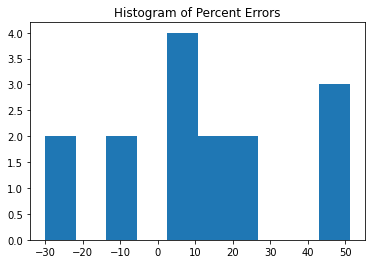

In [ ]:
uts.evaluate(y_yhat)

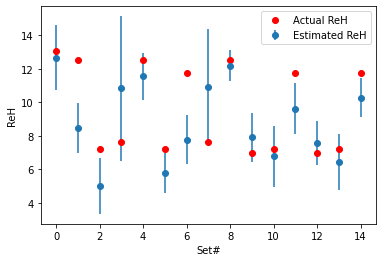

In [ ]:
uts.plotError(y_yhat, err, "ReH")

# ReE

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)

Mean percent error:  24.937903437268165
RMSE:  11.977313682030905
RMSE w yhat=mean:  2.525480507907797
R-squared:  -21.492141429728097


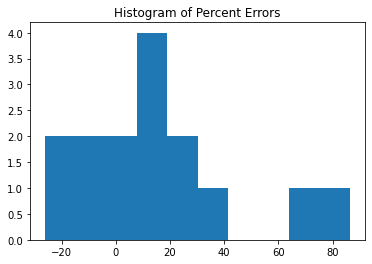

In [ ]:
uts.evaluate(y_yhat)

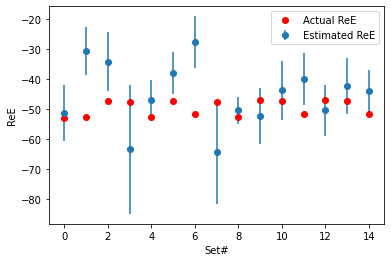

In [ ]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  12.741743220340433
RMSE:  1.0009097318319014
RMSE w yhat=mean:  1.4030345621243818
R-squared:  0.4910758208641146


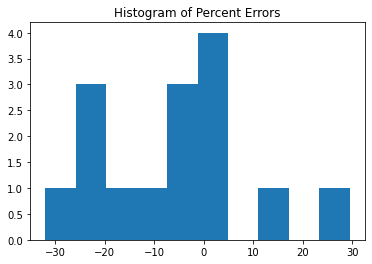

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

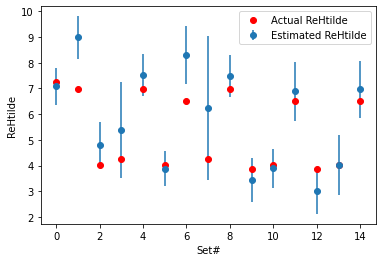

In [ ]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  5.381479640879594
RMSE:  0.0026832633607798144
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9713609566723097


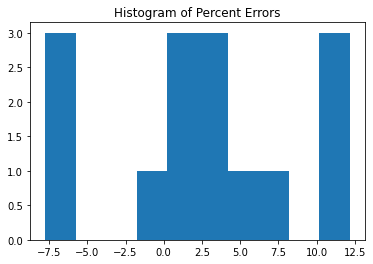

In [ ]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

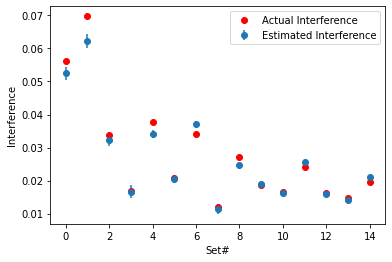

In [ ]:
uts.plotError(y_yhat, err, "Interference")